In [83]:
import gym
import time
import torch as T
import torch.nn as nn
from supersuit import frame_stack_v1, color_reduction_v0
from supersuit import frame_skip_v0, max_observation_v0, dtype_v0, resize_v0, clip_reward_v0
from torchvision import transforms
from einops import rearrange
import matplotlib.pyplot as plt
import torch.nn.functional as F
import kornia as K
import numpy as np

In [84]:
def crop_bottom(x):
    return x[:,:,:172,:]

In [85]:
def preprocess(img):
    img = T.from_numpy(img).unsqueeze(0) / 255
    img = rearrange(img, 'b h w c -> b c h w')
    
    return img

In [106]:
def plot_state(state, big=False):
    fig = plt.figure(figsize=(24,12))
    if big:
        plt.imshow(state[0][0], cmap='gray');
        return
    
    for i in range(state.shape[1]):
        fig.add_subplot(1, FRAMES_TO_STACK, i + 1)
        plt.imshow(state[0][i], cmap='gray');

In [90]:
FRAMES_TO_STACK = 4
FRAMES_TO_SKIP = 4
MAX_OVER_OBS = 4

X_DIM = 84
Y_DIM = 84

In [118]:
env = gym.make('MsPacman-v4')
env = clip_reward_v0(env, lower_bound=-1, upper_bound=1)
env = resize_v0(env, X_DIM, Y_DIM, linear_interp=True)
env = color_reduction_v0(env, 'full')
#env = color_reduction_v0(env, 'R')
#env = max_observation_v0(env, MAX_OVER_OBS)
env = frame_stack_v1(env, FRAMES_TO_STACK)
env = frame_skip_v0(env, FRAMES_TO_SKIP)
env = dtype_v0(env, np.float32)

NUM_ACTIONS = gym.spaces.utils.flatdim(env.action_space)

In [119]:
done = False
s = env.reset()
i = 0
rewards = []
render = False

while not done:
    if render:
        env.render()
        time.sleep(1/60)
    action = env.action_space.sample()
    s, r, done, _ = env.step(action)

    i += 1
    rewards.append(r)
    if i == 100: break
    
env.close()

In [120]:
s = preprocess(s)

In [121]:
class ContrastiveLearner(nn.Module):
    def __init__(self, num_actions, frame_stack, resnet_dim=2048, project_dim=2048):
        super(ContrastiveLearner, self).__init__()
        
        self.encoder = models.resnet50(pretrained=False, num_classes=resnet_dim)
        # self.encoder.conv1 = nn.Conv2d(frame_stack, 64, (7, 7), (2, 2), (3, 3), bias=False)
        self.layer_norm = nn.LayerNorm(resnet_dim)
        
        self.project_head = nn.Sequential(
            nn.Linear(resnet_dim, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, project_dim)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.layer_norm(x)
        x = T.tanh(x)
        
        return x
    
    def encode(self, x):
        return self.forward(x)
    
    def project(self, x):
        x = self.forward(x)
        x = self.project_head(x)
        
        return x

In [122]:
class DataAugment(nn.Module):
    def __init__(self):
        super().__init__()

        #self.jitter = K.augmentation.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0)
        
        # TODO change to rotation
        self.flip = nn.Sequential(
            K.augmentation.RandomHorizontalFlip(p=0.5),
            K.augmentation.RandomVerticalFlip(p=0.5)
        )
    
    @T.no_grad()
    def forward(self, x):
        #x = self.jitter(x)
        x = self.flip(x)
        
        return x

In [114]:
dm = DataAugment()

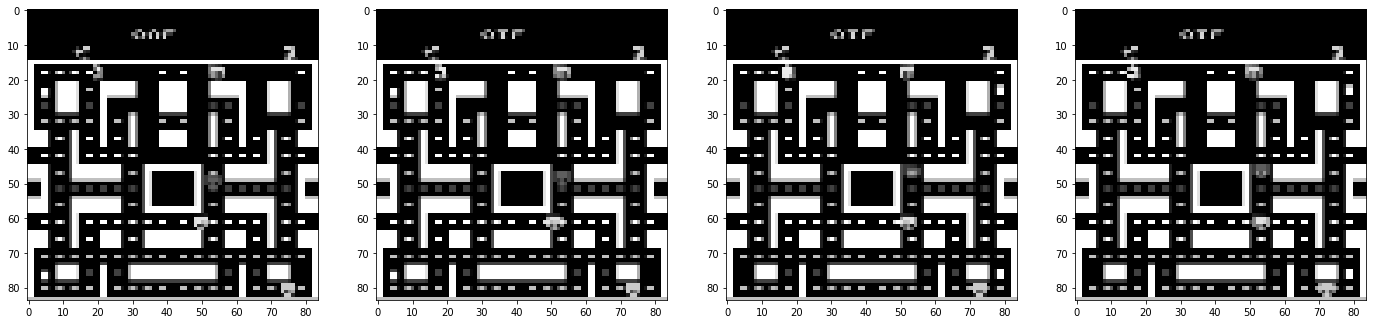

In [115]:
plot_state(dm(s))